In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
products_df = pd.read_csv("../data/products.csv", sep=";")[["category", "name"]]
products_df.head()

,category,name
0,Канцтовары,"Скетчбук А5, блокнот для скетчинга"
1,Канцтовары,Блокнот
2,Канцтовары,"для принтера, 2500"
3,Канцтовары,Бумага а4 для принтера оргтехники
4,Канцтовары,Бумага а4 для принтера оргтехники


In [3]:
tfidf_df = pd.read_csv('../data/tfidf_terms.csv', index_col=0)
tfidf_df.sample(5)

,category,term,tf_idf
32637,Мужчинам,одноразов,0.000066
17491,Дом,быстрый,0.000103
27281,Зоотовары,курицей,0.000947
15579,Бытовая техника,ароматизатор,0.001384
6543,Электроника,cam,0.002447


In [4]:
import sys
sys.path.append('..')

In [5]:
from hoko.impurity import gini_impurity, gini_split

In [6]:
threshold = .0032659251981170456
threshold

0.0032659251981170456

In [7]:
tfidf_df = tfidf_df.loc[tfidf_df["tf_idf"] > threshold].sort_values(by="tf_idf", ascending=False)
tfidf_df.head()

,category,term,tf_idf
17123,Обувь,ботинк,0.199542
5316,Ювелирные изделия,925,0.094208
47470,Ювелирные изделия,ювелирн,0.087382
26596,Зоотовары,кошек,0.077405
39588,Ювелирные изделия,серьг,0.074053


In [8]:
def df_split(*, df: pd.DataFrame, token: str | list[str], anti_token: str | list[str], expected_class: str, relation: str = "token in"):
    """relation : `token in` or `token not in`
    """
    if relation not in ("token in", "token not in"):
        msg = "relation must be `token in` or `token not in`"
        raise ValueError(msg)
    
    if isinstance(token, str):
        token = [token,]
    
    if isinstance(anti_token, str):
        anti_token = [anti_token,]
    
    def check_ok(line):
        ll = line.lower()
        return any([t in ll for t in token]) and not any([at in ll for at in anti_token])
    
    mask = products_df["name"].apply(lambda x: check_ok(x))
    split_left = products_df.loc[mask]
    split_right = products_df.loc[~mask]
    
    evaluate_split = split_left if relation == "token in" else split_right
    k, v = np.unique(evaluate_split["category"] == expected_class, return_counts=True)
    d = { kk : vv for kk, vv in zip(k, v) }
    ngood = d.get(True, 0)
    nbad = d.get(False, 0)
    
    if relation != "token in":
        ngood, nbad = nbad, ngood
    
    gini_split_score = gini_split(ngood, nbad)
    
    return split_left, split_right, gini_split_score

In [9]:
def learn_class(*, _df: pd.DataFrame, _tf_idf: pd.DataFrame, expected_class: str):
    tf_idf_left = _tf_idf
    
    top_10 = tf_idf_left.loc[tf_idf_left["category"] == expected_class].sort_values(by="tf_idf", ascending=False)["term"][:10]
    tf_idf_left = tf_idf_left.loc[tf_idf_left["term"].apply(lambda x: x not in top_10)]

---

In [10]:
def quick_mask(*, df: pd.DataFrame, token: str, expected_class: str, not_in = False):
    mask = df["name"].apply(lambda x: token not in x.lower() if not_in else token in x.lower())
    split_left = df.loc[mask]
    split_right = df.loc[~mask]
    
    evaluate_split = split_left
    k, v = np.unique(evaluate_split["category"] == expected_class, return_counts=True)
    d = { kk : vv for kk, vv in zip(k, v) }
    ngood = d.get(True, 0)
    nbad = d.get(False, 0)
    
    return gini_impurity([ngood, nbad])

In [11]:
tf_idf_left = tfidf_df

good_terms = tf_idf_left.loc[tf_idf_left["category"] == "Обувь"].sort_values(by="tf_idf", ascending=False)["term"]
# tf_idf_left = tf_idf_left.loc[tf_idf_left["term"].apply(lambda x: x not in top_10)]
good_terms.shape[0], good_terms.head()

(71,
 17123      ботинк
 23298        зимн
 38956       сапог
 46683       шнурк
 26987    кроссовк
 Name: term, dtype: object)

In [12]:
%%time
good_gini_scores = [
    quick_mask(
        df=products_df,
        token=token,
        expected_class="Обувь"
    )
    for token in good_terms
]

CPU times: user 3.86 s, sys: 5.01 ms, total: 3.86 s
Wall time: 3.92 s


In [13]:
top10_good_terms = good_terms.iloc[np.argsort(good_gini_scores)[:10]]
top10_good_terms

26988     кроссовок
17127       ботфорт
7053       crocband
38224         рожок
21228       джибитс
35198        подошв
35665    полусапожк
11873          qing
6058           baya
29844      мистраль
Name: term, dtype: object

In [14]:
def check_in(line, toks):
    if len(toks) == 0:
        return True
    line = line.lower()
    return any([t in line for t in toks])

def check_not_in(line, toks):
    if len(toks) == 0:
        return True
    line = line.lower()
    return all([t not in line for t in toks])

def learn_class(*, _df: pd.DataFrame, _tfidf: pd.DataFrame, expected_class: str):
    good_terms = _tfidf["term"].loc[_tfidf["category"] == expected_class]
    
    good_gini_scores = [
        quick_mask(
            df=_df,
            token=token,
            expected_class=expected_class,
        )
        for token in good_terms
    ]
    
    top10_good_terms = good_terms.iloc[np.argsort(good_gini_scores)[:10]].to_list()
    
    good_df = _df.loc[_df["name"].apply(lambda x: check_in(x, top10_good_terms))]
    
    if good_df["category"].unique().shape[0] == 1:
        return top10_good_terms, []
    
    
    bad_terms = _tfidf["term"].loc[_tfidf["category"] != expected_class]
    
    bad_gini_scores = [
        quick_mask(
            df=good_df,
            token=token,
            expected_class=expected_class,
            not_in=True
        )
        for token in bad_terms
    ]
    
    top10_bad_terms = bad_terms.iloc[np.argsort(bad_gini_scores)[:10]].to_list()
    
    return top10_good_terms, top10_bad_terms

In [15]:
products_df["category"].unique()

array(['Канцтовары', 'Женщинам', 'Дом', 'Мужчинам', 'Книги', 'Аксессуары',
       'Зоотовары', 'Обувь', 'Мебель', 'Бытовая техника', 'Красота',
       'Здоровье', 'Для ремонта', 'Автотовары', 'Продукты', 'Игрушки',
       'Электроника', 'Детям', 'Ювелирные изделия', 'Сад и дача'],
      dtype=object)

In [16]:
from tqdm.notebook import tqdm

In [17]:
def learn_all(*, _df: pd.DataFrame, _tfidf: pd.DataFrame):
    all_categories = _df["category"].unique()
    
    out = dict()
    
    for category in tqdm(all_categories):
        print(category)
        t_in, t_not_in = learn_class(
            _df=_df,
            _tfidf=_tfidf,
            expected_class=category,
        )
        
        out[category] = t_in, t_not_in
        
        # _df = _df.loc[_df["name"].apply(lambda x: not (check_in(x, t_in) and check_not_in(x, t_not_in)))]
        _df = _df.loc[~_df["name"].apply(lambda x: check_in(x, t_in) and check_not_in(x, t_not_in))]
    
    return out

In [18]:
out = learn_all(
    _df=products_df,
    _tfidf=tfidf_df,
)

out

  0%|          | 0/20 [00:00<?, ?it/s]

Канцтовары


/home/danila/Projects/hokokuji/notebooks/../hoko/impurity.py:6: RuntimeWarning: invalid value encountered in divide
  return 1 - ((counts / counts.sum()) ** 2).sum()


Женщинам
Дом
Мужчинам
Книги
Аксессуары
Зоотовары
Обувь
Мебель
Бытовая техника
Красота
Здоровье
Для ремонта
Автотовары
Продукты
Игрушки
Электроника
Детям
Ювелирные изделия
Сад и дача


{'Канцтовары': (['учебников',
   'меловой',
   'счетных',
   'канцелярский',
   'физический',
   'материалов',
   'акварел',
   'датированный',
   'фломастеров',
   'а7'],
  []),
 'Женщинам': (['разрезом',
   'рубчик',
   'посадкой',
   'талией',
   'топик',
   'стринг',
   'вырезом',
   'блузк',
   'юбк',
   'вечерн'],
  ['школьн',
   'школьн',
   'коль',
   'ев',
   '925',
   'серьг',
   'форм',
   'серебр',
   'девочк',
   'девочк']),
 'Дом': (['палочкам',
   'стирк',
   'кальян',
   'блэкаут',
   'чарон',
   'стирок',
   'стиральный',
   'бязь',
   'зажигалк',
   '70х70'],
  ['мягк',
   'стен',
   'пвх',
   'стенов',
   'ассорт',
   'спрей',
   'конфет',
   'панел',
   'рт',
   'рт']),
 'Мужчинам': (['приталенн',
   'бойфренд',
   'карг',
   'zxc',
   'инсайд',
   'джоггер',
   'пуловер',
   'зауженн',
   'полукомбинезон',
   'туфл'],
  ['женск',
   'женск',
   'женск',
   'женск',
   'лук',
   'туфл',
   'кож',
   'кож',
   'комбинезон',
   'бин']),
 'Книги': (['вариантов',
   'уэ

In [19]:
class Stump:
    def __init__(self, rule, label):
        self.good = rule[0]
        self.bad = rule[1]
        self.label = label
    
    def predict(self, Nrows):
        if isinstance(Nrows, str):
            Nrows = [Nrows,]
        Nrows = [row.lower() for row in Nrows]
        return [
            self.label if (
                any([g in row for g in self.good])
                and not any([b in row for b in self.bad])
            ) else ""
            for row in Nrows
        ]

In [20]:
class Model:
    def __init__(self, rules):
        self.rules = rules
        self.outputs = np.array(list(rules.keys()))
        self.stumps = [Stump(rule, label) for label, rule in rules.items()]
    
    def predict(self, Nrows):
        if isinstance(Nrows, str):
            Nrows = [Nrows,]
        Nrows = [row.lower() for row in Nrows]
        
        preds = np.array([
            max([s.predict(row)[0] for s in self.stumps])
            for row in Nrows
        ])
        # preds = np.array([ s.predict(Nrows) for s in self.stumps ])
        return preds
        
        return self.outputs[preds.argmax(axis=0).T]

In [21]:
M = Model(out)

In [22]:
F = M.predict(products_df["name"].to_list())
# preds = M.predict(lines)

In [23]:
(F == products_df["category"]).sum() / products_df.shape[0]

0.13159656704607706

In [24]:
def compile_to_sql(rules, column_name="some_txt"):
    out = "(case\n"
    
    for k, (tin, tout) in rules.items():
        out += f"""  when 1=1\n    and lower({column_name}) like '%({"|".join(tin)})%'\n"""
        
        if tout != []:
            out += f"""    and lower({column_name}) not like '%({"|".join(tout)})%'\n"""
    
        out += f"    then '{k}'\n\n"
        
    out += "  else Null\n"
    out += "end)"
    
    return out

In [25]:
print(compile_to_sql(out, column_name="name"))

(case
  when 1=1
    and lower(name) like '%(учебников|меловой|счетных|канцелярский|физический|материалов|акварел|датированный|фломастеров|а7)%'
    then 'Канцтовары'

  when 1=1
    and lower(name) like '%(разрезом|рубчик|посадкой|талией|топик|стринг|вырезом|блузк|юбк|вечерн)%'
    and lower(name) not like '%(школьн|школьн|коль|ев|925|серьг|форм|серебр|девочк|девочк)%'
    then 'Женщинам'

  when 1=1
    and lower(name) like '%(палочкам|стирк|кальян|блэкаут|чарон|стирок|стиральный|бязь|зажигалк|70х70)%'
    and lower(name) not like '%(мягк|стен|пвх|стенов|ассорт|спрей|конфет|панел|рт|рт)%'
    then 'Дом'

  when 1=1
    and lower(name) like '%(приталенн|бойфренд|карг|zxc|инсайд|джоггер|пуловер|зауженн|полукомбинезон|туфл)%'
    and lower(name) not like '%(женск|женск|женск|женск|лук|туфл|кож|кож|комбинезон|бин)%'
    then 'Мужчинам'

  when 1=1
    and lower(name) like '%(вариантов|уэйт|метафорическ|квартальный|руководств|ассоциативн|томах|годовой|библ|издан)%'
    and lower(name) not

In [26]:
from sqlalchemy import create_engine

engine = create_engine('postgresql://danila@localhost/wildberries')
engine

Engine(postgresql://danila@localhost/wildberries)

In [27]:
%load_ext sql

In [28]:
%sql postgresql://danila@localhost:5432/wildberries

In [29]:
%%sql

drop table if exists predicted_category;

 * postgresql://danila@localhost:5432/wildberries
Done.


[]

In [30]:
%%time
test_df = pd.read_sql(
    sql="select category, name from raw.products",
    con=engine,
)


test_df["pred_category"] = M.predict(test_df["name"].to_list())

test_df.to_sql(name="predicted_category", con=engine)

CPU times: user 5.25 s, sys: 29.9 ms, total: 5.28 s
Wall time: 5.86 s


152

In [31]:
%%sql

drop table if exists predicted_category;

 * postgresql://danila@localhost:5432/wildberries
Done.


[]

In [32]:
%%time
test_df = pd.read_sql(
    sql="select category, name from raw.products",
    con=engine,
)


# test_df["pred_category"] = M.predict(test_df["name"].to_list())

test_df.to_sql(name="predicted_category", con=engine)

CPU times: user 881 ms, sys: 16.3 ms, total: 897 ms
Wall time: 1.35 s


152

In [33]:
%%sql

drop table if exists predicted_category;

 * postgresql://danila@localhost:5432/wildberries
Done.


[]

In [34]:
%%time
%%sql

create table predicted_category as

select
     category as true_category
    ,(case
      when 1=1
        and lower(name) like '%(учебников|счетных|канцелярский|физикополитический|физический|материалов|акварел|датированный|фломастеров|а7)%'
        then 'Канцтовары'
    
      when 1=1
        and lower(name) like '%(разрезом|рубчик|посадкой|талией|топик|стринг|вырезом|блузк|юбк|вечерн)%'
        and lower(name) not like '%(школьн|школьн|коль|ев|925|серьг|форм|серебр|девочк|девочк)%'
        then 'Женщинам'
    
      when 1=1
        and lower(name) like '%(палочкам|наклонноповоротный|стирк|кальян|стиральный|стирок|чарон|бязь|блэкаут|зажигалк)%'
        and lower(name) not like '%(ассорт|рт|конфет|спрей|рт|ботинк|подушк|total|шампуров|пистолетмаркиратор)%'
        then 'Дом'
    
      when 1=1
        and lower(name) like '%(приталенн|карг|zxc|футболкапол|инсайд|бойфренд|джоггер|пуловер|зауженн|полукомбинезон)%'
        and lower(name) not like '%(женск|женск|женск|женск|лук|комбинезон|комбинезон|бин|кожан|кож)%'
        then 'Мужчинам'
    
      when 1=1
        and lower(name) like '%(руководств|годовой|квартальный|библ|томах|cdmp3|ассоциативн|cdмр3|метафорическ|уэйт)%'
        then 'Книги'
    
      when 1=1
        and lower(name) like '%(нашивк|шеврон|твилл|вагнер|канекалон|платков|антиветер|носовых|портуп|кладь)%'
        then 'Аксессуары'
    
      when 1=1
        and lower(name) like '%(нагреватель|инкубатор|когтерез|фурминатор|кроликов|аквариумный|груминг|вольер|пуходерк|средних)%'
        then 'Зоотовары'
    
      when 1=1
        and lower(name) like '%(джибитс|ботфорт|crocband|baya|завязок|qing|подошв|рожок|полусапожк|кроссовок)%'
        then 'Обувь'
    
      when 1=1
        and lower(name) like '%(квадратный|раскладной|обеденног|журнальный|7301757250|банкетк|беспружинный|письменный|eames|кресломешок)%'
        then 'Мебель'
    
      when 1=1
        and lower(name) like '%(увлажнитель|мойщик|конвектор|стеклоочиститель|эпилятор|puh|антивибрационн|4100k|планетарный|pvcr)%'
        then 'Бытовая техника'
    
      when 1=1
        and lower(name) like '%(spf|крылышкам|термозащит|причесок|dercos|солнцезащитный|парикмахерский|results|парикмахерск|тональный)%'
        then 'Красота'
    
      when 1=1
        and lower(name) like '%(кузнецов|послеродовой|безалкогольный|кордицепс|аппликатор|стерилизац|изопропиловый|мицелий|микродозинг|кровоостанавливающий)%'
        then 'Здоровье'
    
      when 1=1
        and lower(name) like '%(флизелинов|сантехнический|рештк|стенов|шпагат|gdf|грунтовк|фотооб|приточный|теплоизоляц)%'
        then 'Для ремонта'
    
      when 1=1
        and lower(name) like '%(стартер|honda|багажник|стеклоочистител|renault|mitsubishi|зажиган|sae|присадк|kia)%'
        then 'Автотовары'
    
      when 1=1
        and lower(name) like '%(снек|коктейлей|тушенк|сухофрукт|пастил|арабик|финик|вялен|зернах|жареный)%'
        then 'Продукты'
    
      when 1=1
        and lower(name) like '%(формочк|румбокс|бластер|игрушечный|водой|мыльных|пузырей|гуджитс|песочниц|мыльн)%'
        then 'Игрушки'
    
      when 1=1
        and lower(name) like '%(ipкамер|звонок|ps4|8gb|bank|штрихкод|128gb|64gb|электромобиль|core)%'
        then 'Электроника'
    
      when 1=1
        and lower(name) like '%(914|914кг|monkey|airsilky|выписк|мембранной|yoursun|1217кг|611|подгузникитрусик)%'
        and lower(name) not like '%(вытяжк|кухонн|секатор|стикер|наручн|приготовлен|подушк|total|шампуров|семен)%'
        then 'Детям'
    
      when 1=1
        and lower(name) like '%(ювелирных|кулон|бриллиантам|пупок|бриллиантом|пусет|фианит|полновесн|бисмарк|серебряный)%'
        then 'Ювелирные изделия'
    
      when 1=1
        and lower(name) like '%(фитосветильник|клопов|шампуров|спальник|парник|шашлычный|спанбонд|сорняков|биотуалетов|теплиц)%'
        then 'Сад и дача'
    
      else Null
    end) as pred_category
    ,name
from
    raw.products
;

 * postgresql://danila@localhost:5432/wildberries
67152 rows affected.
CPU times: user 70.6 ms, sys: 0 ns, total: 70.6 ms
Wall time: 1.36 s


[]

In [35]:
%%sql

select
    count(1)
from
    raw.products

 * postgresql://danila@localhost:5432/wildberries
1 rows affected.


count
67152


In [36]:
import matplotlib.pyplot as plt

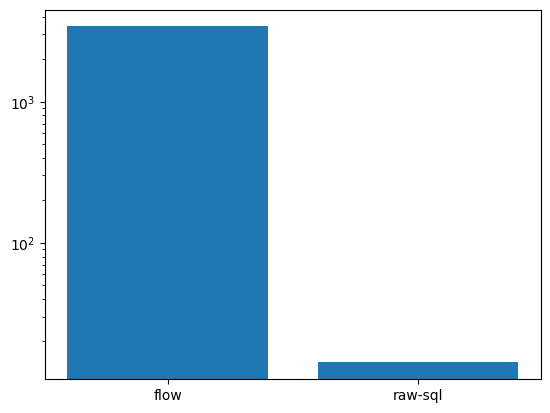

In [37]:
plt.bar(
    x=["flow", "raw-sql",],
    height=[3.41 * 1000, 14.2],
);
plt.yscale("log");
plt.show()